In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('btc_in_sample_data.csv')
# Parameters for Bollinger Bands
period = 20  # Lookback period for SMA and Standard Deviation
multiplier = 2  # Standard deviation multiplier

# Compute Bollinger Bands
data['SMA'] = data['Close'].rolling(window=period).mean()
data['STD'] = data['Close'].rolling(window=period).std()
data['Upper Band'] = data['SMA'] + (multiplier * data['STD'])
data['Lower Band'] = data['SMA'] - (multiplier * data['STD'])

# Add Buy/Sell Signals
data['Buy Signal'] = data['Close'] > data['Upper Band']
data['Sell Signal'] = data['Close'] < data['Lower Band']

# Drop rows with NaN values
data.dropna(inplace=True)

# Display the first few rows
display(data[['Close', 'SMA', 'Upper Band', 'Lower Band', 'Buy Signal', 'Sell Signal']].head())

,Close,SMA,Upper Band,Lower Band,Buy Signal,Sell Signal
19,4285.08,4360.5715,4487.227633,4233.915367,False,False
20,4286.53,4359.4565,4488.402456,4230.510544,False,False
21,4243.59,4355.8700,4493.670992,4218.069008,False,False
22,4267.59,4353.0320,4495.814168,4210.249832,False,False
23,4292.39,4350.1520,4495.493240,4204.810760,False,False


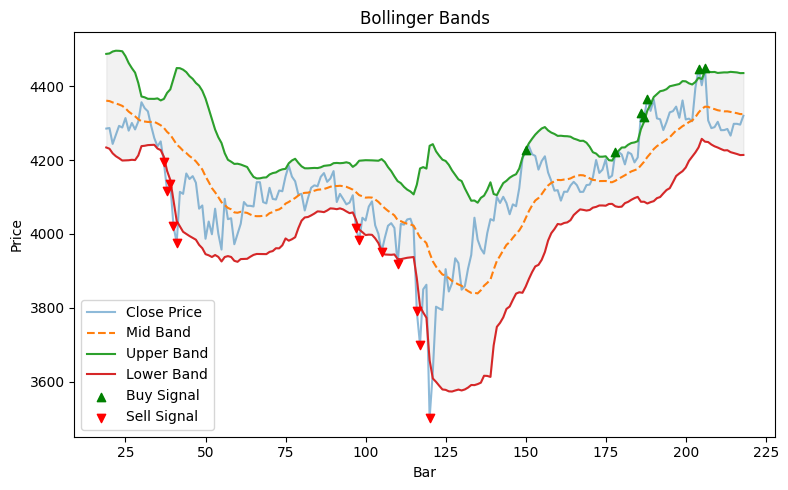

In [3]:
# Some visualization

data_subset = data.iloc[:200, :].copy()
# Buy and Sell Signal markers
data_subset['Buy Marker'] = data_subset['Close'][data_subset['Buy Signal']]
data_subset['Sell Marker'] = data_subset['Close'][data_subset['Sell Signal']]

# Plot Bollinger Bands
plt.figure(figsize=(8, 5))
plt.plot(data_subset.index, data_subset['Close'], label='Close Price', alpha=0.5)
plt.plot(data_subset.index, data_subset['SMA'], label='Mid Band', linestyle='--')
plt.plot(data_subset.index, data_subset['Upper Band'], label='Upper Band')
plt.plot(data_subset.index, data_subset['Lower Band'], label='Lower Band')
plt.fill_between(data_subset.index, data_subset['Lower Band'], data_subset['Upper Band'], color='gray', alpha=0.1)

# markers for Buy/Sell signals
plt.scatter(data_subset.index, data_subset['Buy Marker'], label='Buy Signal', marker='^', color='green', zorder=5)
plt.scatter(data_subset.index, data_subset['Sell Marker'], label='Sell Signal', marker='v', color='red', zorder=5)

plt.title('Bollinger Bands')
plt.xlabel('Bar')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# Count total signals
buy_count = data['Buy Signal'].sum()
sell_count = data['Sell Signal'].sum()
total_signals = buy_count + sell_count
signal_percentage = (total_signals / len(data)) * 100

print(f"Buy Signals: {buy_count}")
print(f"Sell Signals: {sell_count}")
print(f"Total Signals: {total_signals}")
print(f"Signal Percentage: {signal_percentage:.2f}%")

Buy Signals: 2670
Sell Signals: 2674
Total Signals: 5344
Signal Percentage: 11.38%


In [5]:
periods_to_check = [5, 10, 20, 40, 80, 160]

# Define function for forward returns after signals for multiple periods
def forward_returns(df, signal_col, price_col, periods=periods_to_check):
    results = {}
    for period in periods:
        future_returns = []
        for idx in df.index[df[signal_col]]:
            if idx + period < len(df):
                # Calculate the forward return
                return_pct = (df[price_col].iloc[idx + period] / df[price_col].iloc[idx]) - 1
                future_returns.append(return_pct)
        results[period] = future_returns
    return results

# Calculate forward returns for buy and sell signals
buy_forward_returns = forward_returns(data, 'Buy Signal', 'Close')
sell_forward_returns = forward_returns(data, 'Sell Signal', 'Close')

# Invert the sell forward returns to make them positive (since sell signals represent negative returns)
sell_forward_returns = {period: [-x for x in returns] for period, returns in sell_forward_returns.items()}

   Holding Period  Forward Return
0               5        0.010138
1               5       -0.009106
2               5       -0.022477
3               5       -0.037928
4               5       -0.006076
   Holding Period  Forward Return
0               5        0.016515
1               5       -0.011498
2               5       -0.008339
3               5       -0.026165
4               5       -0.018558


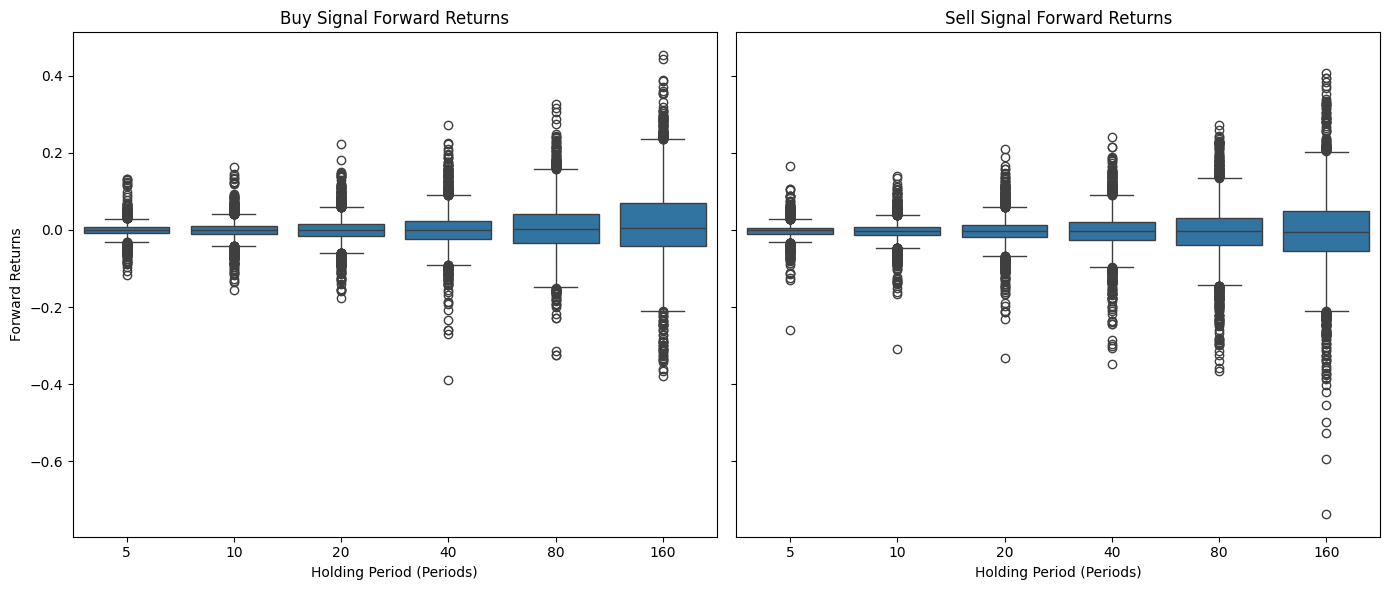

In [6]:
# Create a dataframe for the buy signals
df_box_buy = pd.DataFrame({
    'Holding Period': [period for period in periods_to_check for _ in range(len(buy_forward_returns[period]))],
    'Forward Return': np.concatenate([buy_forward_returns[period] for period in periods_to_check]),
})

# Create a dataframe for the sell signals
df_box_sell = pd.DataFrame({
    'Holding Period': [period for period in periods_to_check for _ in range(len(sell_forward_returns[period]))],
    'Forward Return': np.concatenate([sell_forward_returns[period] for period in periods_to_check])
})

print(df_box_buy.head())
print(df_box_sell.head())

# Plot the box plot with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for Buy signals (left subplot)
sns.boxplot(x='Holding Period', y='Forward Return', data=df_box_buy, ax=axes[0])
axes[0].set_title('Buy Signal Forward Returns')
axes[0].set_xlabel('Holding Period (Periods)')
axes[0].set_ylabel('Forward Returns')

# Plot for Sell signals (right subplot)
sns.boxplot(x='Holding Period', y='Forward Return', data=df_box_sell, ax=axes[1])
axes[1].set_title('Sell Signal Forward Returns')
axes[1].set_xlabel('Holding Period (Periods)')
axes[1].set_ylabel('Forward Returns')

# Show the plot
plt.tight_layout()
plt.show()

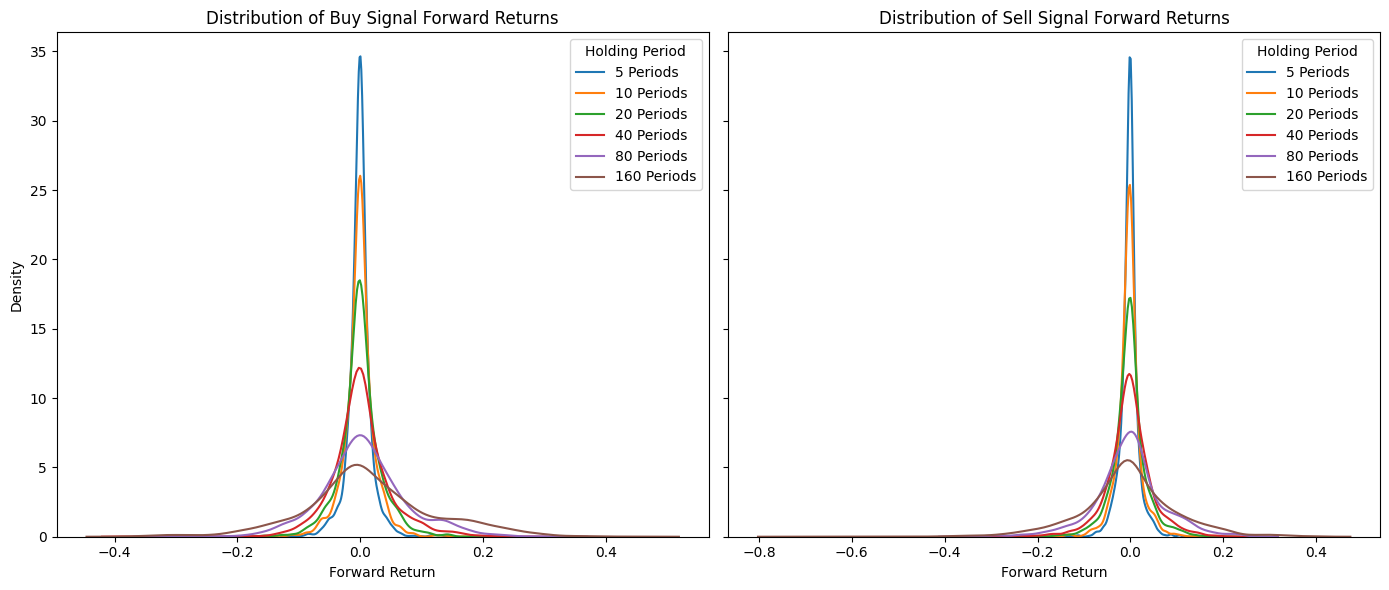

In [7]:
# Plot the distribution for Buy signals (left) and Sell signals (right)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot the distribution for Buy signals (left subplot)
for period in periods_to_check:
    sns.kdeplot(buy_forward_returns[period], label=f'{period} Periods', fill=False, ax=axes[0])
axes[0].set_title('Distribution of Buy Signal Forward Returns')
axes[0].set_xlabel('Forward Return')
axes[0].set_ylabel('Density')
axes[0].legend(title='Holding Period')

# Plot the distribution for Sell signals (right subplot)
for period in periods_to_check:
    sns.kdeplot(sell_forward_returns[period], label=f'{period} Periods', fill=False, ax=axes[1])
axes[1].set_title('Distribution of Sell Signal Forward Returns')
axes[1].set_xlabel('Forward Return')
axes[1].set_ylabel('Density')
axes[1].legend(title='Holding Period')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [8]:
# Function to calculate statistics
def calculate_statistics(forward_returns):
    statistics = {}
    for period, returns in forward_returns.items():
        # Calculate statistics
        mean_return = np.mean(returns) * 100  # Convert mean return to percentage
        median_return = np.median(returns) * 100  # Convert median return to percentage
        std_dev = np.std(returns) * 100  # Convert std dev to percentage
        skewness = skew(returns * 100)
        kurtosis_value = kurtosis(returns * 100)
        
        # Calculate winrate and number of trades
        winrate = np.mean(np.array(returns) > 0) * 100  # Percentage of positive returns
        
        # Calculate average win and average loss
        positive_returns = [r for r in returns if r > 0]
        negative_returns = [r for r in returns if r < 0]
        
        average_win = np.mean(positive_returns) * 100 if positive_returns else 0  # Convert to percentage
        average_loss = np.mean(negative_returns) * 100 if negative_returns else 0  # Convert to percentage
        
        statistics[period] = {
            'Mean (%)': mean_return,
            'Median (%)': median_return,
            'Std Dev (%)': std_dev,
            'Skewness': skewness,
            'Kurtosis': kurtosis_value,
            'Winrate (%)': winrate,
            'Average Win (%)': average_win,
            'Average Loss (%)': average_loss,
        }
    
    return statistics

# Calculate statistics for buy and sell returns
buy_stats = calculate_statistics(buy_forward_returns)
sell_stats = calculate_statistics(sell_forward_returns)

# Convert the results into DataFrames for easier viewing
buy_stats_df = pd.DataFrame(buy_stats).T
sell_stats_df = pd.DataFrame(sell_stats).T

# Display the statistics
display("Buy Signal Statistics:", buy_stats_df)
display("Sell Signal Statistics:", sell_stats_df)


'Buy Signal Statistics:'

,Mean (%),Median (%),Std Dev (%),Skewness,Kurtosis,Winrate (%),Average Win (%),Average Loss (%)
5,-0.098574,-0.051327,1.982464,0.361395,7.497759,47.415730,1.234818,-1.301833
10,-0.128157,-0.067053,2.606254,-0.028111,4.988142,47.827715,1.669832,-1.776422
20,0.007128,-0.082523,3.472574,0.169742,3.487451,48.352060,2.462940,-2.291968
40,0.084201,-0.064338,5.018145,0.134628,4.292430,49.325843,3.581962,-3.320493
80,0.646164,0.254353,7.034744,0.309120,1.502265,52.304234,5.573441,-4.760936
160,1.500575,0.376098,10.696347,0.168180,0.965990,52.288072,8.987402,-6.704328


'Sell Signal Statistics:'

,Mean (%),Median (%),Std Dev (%),Skewness,Kurtosis,Winrate (%),Average Win (%),Average Loss (%)
5,-0.243459,-0.150141,2.064785,-0.670264,14.657595,43.509166,1.224024,-1.373712
10,-0.379226,-0.287033,2.736263,-0.779138,10.145087,41.601197,1.683026,-1.848299
20,-0.300654,-0.223086,3.912490,-0.338587,5.874284,45.059880,2.536650,-2.627707
40,-0.343978,-0.248727,5.188482,-0.511219,4.552102,46.626687,3.429513,-3.640483
80,-0.349205,-0.245006,7.530266,-0.243885,2.137209,48.067542,5.200983,-5.486338
160,-0.530688,-0.590439,10.647111,-0.274788,2.773687,46.576373,7.558843,-7.583392


#### I want to focus on 20 and 40 periods due to my preference for shorter term trading strategies.

In [9]:
from scipy.stats import norm

def plot_with_normal_distribution(data, ax, period_label):
    """Plot KDE and normal distribution on the same axis."""
    sns.kdeplot(data, label=f'{period_label} Periods', fill=False, ax=ax)
    
    # Calculate mean and std dev for normal distribution
    mu, std = np.mean(data), np.std(data)
    
    # Generate x values for the normal distribution curve
    x = np.linspace(min(data), max(data), 100)
    
    # Plot the normal distribution
    ax.plot(x, norm.pdf(x, mu, std), label=f'Normal Distribution ({period_label} periods)', color='red', linestyle='--')

    # Set titles and labels
    ax.set_title(f'{period_label} periods')
    ax.set_xlabel('Forward Return')
    ax.set_ylabel('Density')
    ax.legend()

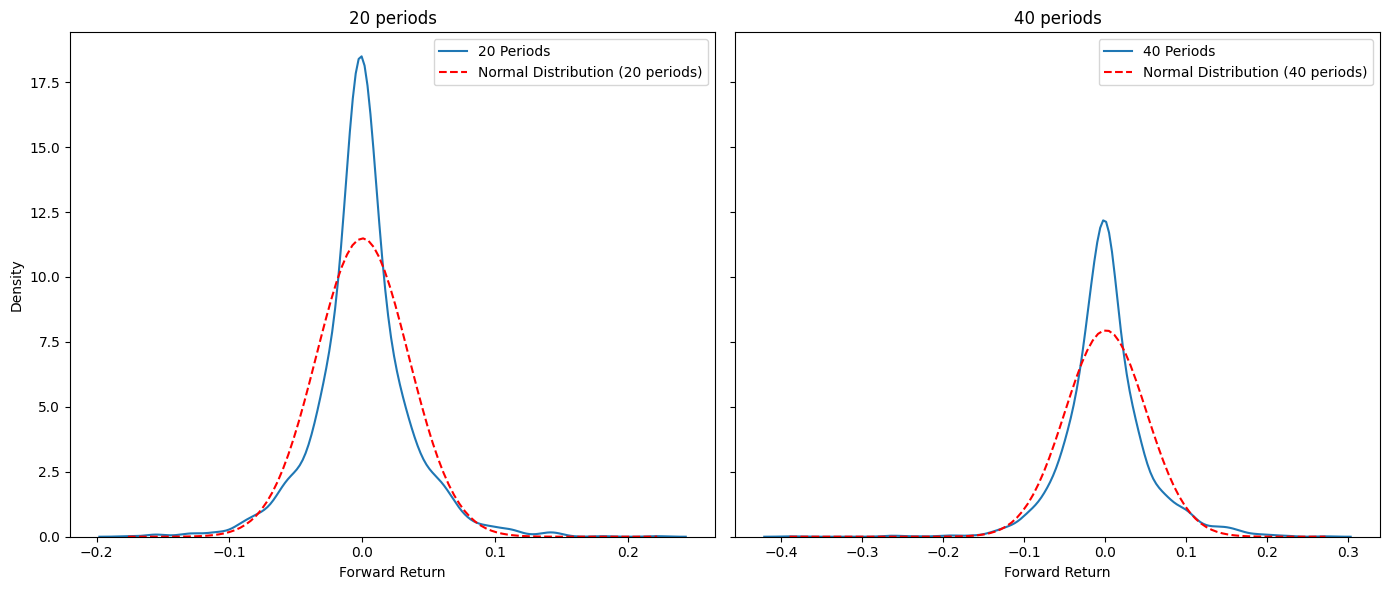

In [10]:
# Plot the distribution for Buy signals (20 and 40 periods)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for 20 and 40 periods using the function
plot_with_normal_distribution(buy_forward_returns[20], axes[0], 20)
plot_with_normal_distribution(buy_forward_returns[40], axes[1], 40)

plt.tight_layout()
plt.show()

## Some thoughts here

1. Buy Signal Analysis:
Profitability: Mean and median returns for buy signals are negative for short holding periods (5, 10, 20) but turn positive for longer periods (80, 100). This suggests profitability improves with holding duration.
Skewness and Kurtosis: Positive skewness and high kurtosis indicate the presence of occasional large profits amidst frequent small losses, supporting the case for trend-following.
Winrate and Risk: While the winrate improves slightly with longer periods (peaking at 52.7% for 100 periods), average losses remain larger than average wins across all periods, highlighting the importance of managing risk effectively.

2. Sell Signal Weakness:
Lower Profitability: Sell signals exhibit negative mean returns and a winrate consistently lower than buy signals, making short trades less effective.
Risk Profile: Larger average losses compared to average wins suggest that shorting strategies underperform in the analyzed market conditions.

3. Strategy Recommendations:
Focus on Buy-Side Strategy: Given the superior performance of buy signals, a long-only strategy aligned with trend-following principles is preferable.
Stop-Loss Implementation: To reduce the impact of noise and mitigate risk, consider using a stop-loss set at approximately 2 standard deviations of price movements. This level balances protection against large losses while avoiding unnecessary exits due to minor fluctuations.
Avoid Shorting: The consistently poor performance of sell signals indicates no clear advantage in short trades under current conditions.

4. Observations on Profit Distribution:
The profit distribution shows no clear statistical advantage in short-term trades. Frequent small losses offset occasional wins, reinforcing the need for a long-term, trend-following approach. A refined stop-loss strategy can help manage the risk of significant drawdowns while enabling the strategy to capitalize on larger trends.
